<a href="https://colab.research.google.com/github/sudhiksha1708/FUTURE_ML_02/blob/main/Customer_Churn_Prediction_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data (1).zip


In [2]:
import pandas as pd, numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier
import shap, joblib, matplotlib.pyplot as plt, seaborn as sns

In [4]:
df = pd.read_csv("/content/Data (1).zip")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0)
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes": 1, "No": 0})

In [6]:
num_features = X.select_dtypes(include=["int64","float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])
cat_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),("cat", cat_transformer, cat_features)])


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = Pipeline(steps=[("preprocessor", preprocessor),("classifier", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))])

model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:23:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [8]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.8151941408974658
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.51      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409



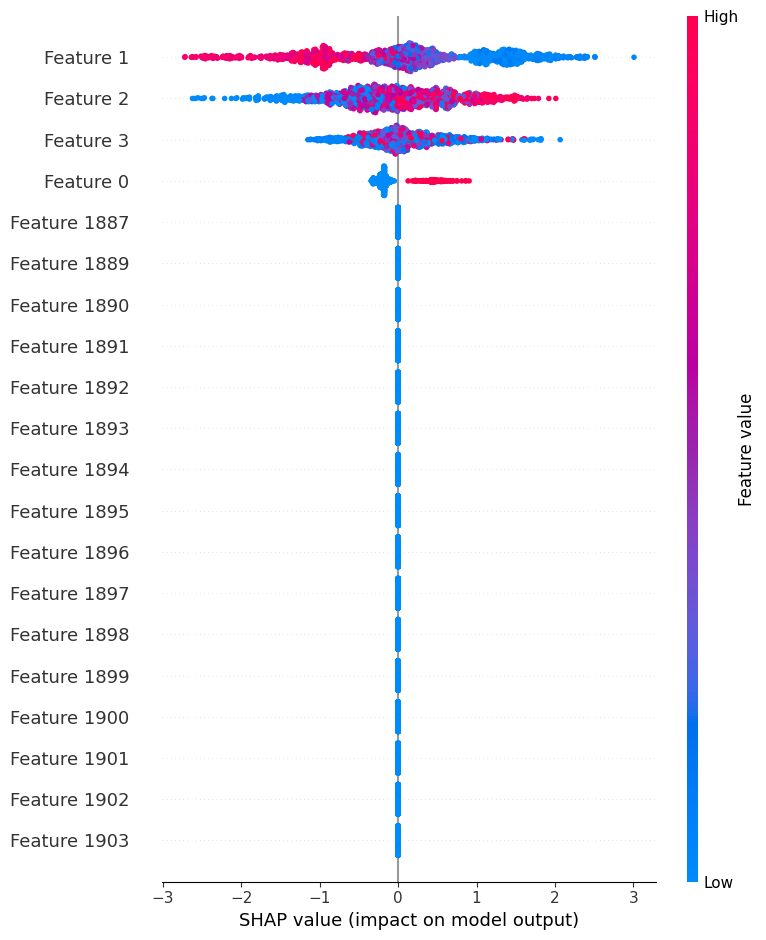

In [9]:
import shap

X_train_transformed = model.named_steps["preprocessor"].transform(X_train).toarray()
X_test_transformed = model.named_steps["preprocessor"].transform(X_test).toarray()

explainer = shap.Explainer(model.named_steps["classifier"], X_train_transformed)
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed)


In [10]:
joblib.dump(model, "churn_model.pkl")

['churn_model.pkl']

In [11]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.772888573456352

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.51      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409



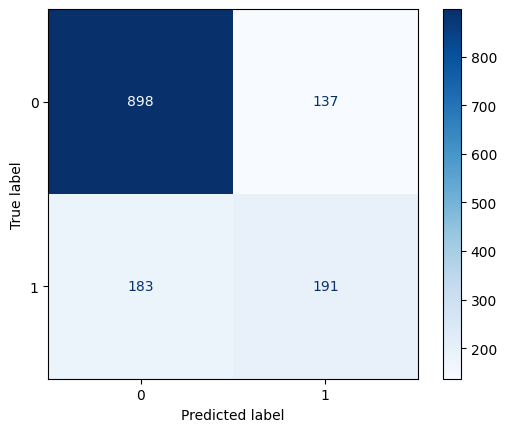

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.show()


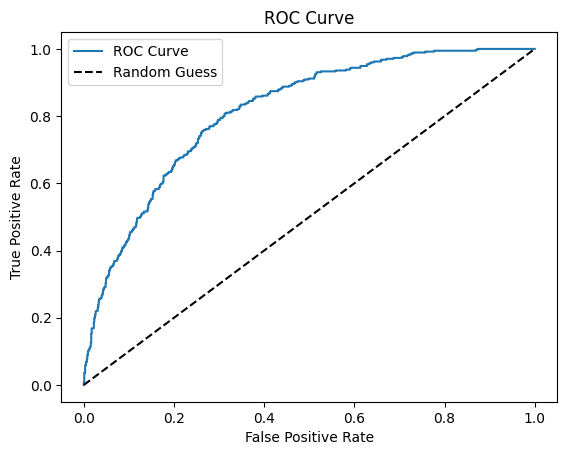

ROC-AUC Score: 0.8151941408974658


In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
